# Design robust Mølmer–Sørensen gates with parametric trap drive amplification
**Obtaining control solutions for two-qubit gates with modulation of the confining potential**

Boulder Opal supports the development of high-performance entangling gates to enhance the quantum volume of trapped-ion quantum computers. Typically, Mølmer–Sørensen-type operations can be used to entangle multiple ions using pairs of lasers with opposite detunings and a fixed phase relationship. This operation can flexibly incorporate multiple entangling operations performed in parallel, or multi-qubit entangling operations using [robust controls](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions) designed using Boulder Opal.  In the [Designing robust, configurable, parallel gates for large trapped-ion arrays](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-configurable-parallel-gates-for-large-trapped-ion-arrays) application note we demonstrate how to combine these various capabilities for complex controls on large multi-ion arrays.  Recent work by [Burd et al.](https://www.nature.com/articles/s41567-021-01237-9) has demonstrated how modulation on the confining potential can be used to realize faster gates.

In this application note, we describe how to combine robust-control optimization in Mølmer–Sørensen gates with parametric modulation of the trap drive.  We will cover:
- Simulating gate dynamics with a parametrically modulated trap drive
- Optimizing Mølmer–Sørensen gates using one and multiple modes
- Calculating phase-space trajectories for arbitrary controls
- Validating performance of robust gates by calculating quasi-static noise susceptibility

Ultimately we demonstrate for the first time that it is possible to combine standard Mølmer–Sørensen-gate optimization techniques with parametric trap-drive modulation in order to achieve fast, robust gates.

## Imports and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv

import boulderopal as bo

plt.style.use(qv.get_qctrl_style())


# Helper function for plotting phase space trajectories.
def plot_phase_space_trajectories(trajectories):
    plot_range = 1.1 * np.max(np.abs(trajectories))
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.suptitle("Phase space trajectories")
    for mode in range(ion_count):
        ax.plot(
            np.real(trajectories[:, 0, mode]),
            np.imag(trajectories[:, 0, mode]),
            label=f"mode {mode % 2}",
        )
        ax.plot(
            np.real(trajectories[-1, 0, mode]),
            np.imag(trajectories[-1, 0, mode]),
            "xk",
            markersize=15,
        )
    ax.set_xlim(-plot_range, plot_range)
    ax.set_ylim(-plot_range, plot_range)
    ax.set_aspect("equal")
    ax.set_xlabel("q")
    ax.set_ylabel("p")
    ax.set_title("$x$-axis")
    ax.legend()
    plt.show()


def reflect_signal(graph, moduli, phases, even_total_segment_count):
    """
    Reflect a drive signal about its temporal midpoint
    and return the combined signal.
    (Milne et al., Phys. Rev. Applied, 2020)
    """

    if even_total_segment_count:
        moduli_refl = graph.reverse(moduli, [0])
        phases_refl = graph.reverse(phases, [0])

    else:
        moduli_refl = graph.reverse(moduli[:-1], [0])
        phases_refl = graph.reverse(phases[:-1], [0])

    moduli_comb = graph.concatenate([moduli, moduli_refl], 0)
    phases_comb = graph.concatenate([phases, 2 * phases[-1] - phases_refl], 0)

    return moduli_comb, phases_comb


def calculate_modulation_parameters(delta, g):
    """
    For a given relative detuning delta and parametric drive strength g,
    return the driven relative detuning
        delta' = sqrt(delta^2 + g^2),
    and the parametric modulation parameter
        r = ln((delta + g) / (delta - g)) / 4.
    """

    delta_prime = np.sqrt(delta**2 - g**2)
    r = np.log((delta + g) / (delta - g)) / 4
    return delta_prime, r

## Creating Boulder Opal pulses for two-qubit gates mediated by a single mode

For standard Mølmer–Sørensen gate-operations, the laser detuning should be close to a motional mode frequency, and the displacements in the phase-space of each mode should be small. At the end of the operation, the phase-space trajectories for each mode should return to zero (for no residual state-motional entanglement) and the phase acquired between each pair of ions should correspond to target entangling phases $\psi_{jk}$ between each pair of ions ($j$, $k$), indexing from 0:

$$ U = \exp\left(i \sum_{j=1}^{N-1} \sum_{k=0}^{j-1} \psi_{jk} \sigma_x^j \sigma_x^k \right). $$

This operation can incorporate multiple entangling operations performed in parallel, or multi-qubit entangling operations; our [multi-qubit gate application note](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-configurable-parallel-gates-for-large-trapped-ion-arrays) equips you to obtain and verify such operations.

Here, we examine how modulation on the confining potential amplifies the mode-mediated gate interaction to provide faster gates as demonstrated recently by [Burd et al.](https://www.nature.com/articles/s41567-021-01237-9). The trap modulation produces the Hamiltonian:

$$H_P = \hbar g (a_p + a_p^\dagger)^2 \cos (\omega_P t + \theta)$$

where $a_p$ is the annihilation operator for motional mode $p$, $g$ is the parametric drive strength, $\omega_P$ is the modulation frequency and $\theta$ is a relative phase term (we set $\theta = 0$). When $\omega_P$ is chosen near resonance with the sideband of mode $p$, and for sufficiently small $g$, just a single mode is modified by the parametric drive. A Bogoliubov normal mode transformation can then be applied to map mode $p$ from the *lab frame* to a *transformed frame*. This transformation can recover the usual Mølmer–Sørensen-type Hamiltonian, but now written in terms of the transformed mode operators in addition to a frequency transformation and a drive transformation (when just a single mode mediates the gate).

We begin by exploring the impact of the trap modulation on the Mølmer–Sørensen gate time and robustness.

First, specify the number and type of ions, as well as other trap and laser characteristics.

In [2]:
# Define trap and laser characteristics.
ion_count = 2
center_of_mass_frequencies = [5.9e6, 6.1e6, 1.5e6]
wavevector = [(2 * np.pi) / 355e-9, 0, 0]
maximum_rabi_rate = 2 * np.pi * 20e3

# Calculate Lamb–Dicke parameters as an array of shape [<axis>, <collective_mode>, <ion>]
# and mode frequencies as an array of shape [<axis>, <collective_mode>].
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=25,  # Mg ions
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=wavevector,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
mode_frequencies = ion_chain_properties["relative_detunings"]

Your task (action_id="1827933") is queued.
Your task (action_id="1827933") has started.
Your task (action_id="1827933") has completed.


Next, the target two-qubit operation is configured by specifying target relative phases between each ion pair. Element ($j$, $k$) of the target phase array is the relative phase between ions $j$ and $k$, with $k<j$. In the cell below the relative phase for ion pair (1, 0) is set to $\pi/4$ for maximal two-qubit entanglement.

In [3]:
target_phases = np.array([[0, 0], [np.pi / 4, 0]])

### Generating standard pulses

The fastest gate is performed by a single displacement loop of the mediating motional mode in phase space. Here we demonstrate this standard operation along with the faster operation produced by adding trap modulation. Note that the gate time is specified by $\pi/\eta \Omega_0$, where $\eta$ is the Lamb Dicke parameter, $\Omega_0$ is the drive strength, and the laser's relative detuning from the motional frequency is $\delta_p = 2 \eta \Omega_0$. The following parameters have been chosen to satisfy these conditions, taking into account the drive and $\delta_p$ transformations when $g>0$ (effectively enhancing the drive strength), as well as the further condition that $|g| < |\delta_p|$.

In [4]:
# Standard gate and control specifications.
all_parameters = {}
all_parameters["Standard"] = {
    "no_g": {
        "g": 0,  # Hz
        "laser_detuning": 5.9e6 - 2.93e3,  # Hz
        "duration": 341.3e-6,  # s
    },
    "low_g": {
        "g": 2.9e3,  # Hz
        "laser_detuning": 5.9e6 - 5.005e3,  # Hz
        "duration": 245.1e-6,  # s
    },
    "high_g": {
        "g": 50e3,  # Hz
        "laser_detuning": 5.9e6 - 50.901e3,  # Hz
        "duration": 104.9e-6,  # s
    },
}

Next we optimize the drive control for the given parameters. In the following optimization, the complex drive $\gamma (t) = \Omega e^{i \phi}$ jointly addresses both ions in the chain such that the gate is mediated only by the center-of-mass mode. The optimizer attempts to minimize a particular cost, which is specified below as the infidelity. Infidelity quantifies the solution performance, and is determined by the final mode displacements, and the difference between the realized and target relative phase.

Note that setting the parameters for the fastest single-loop gate will result in fixed drives close to the maximum Rabi rate to produce this solution. Valid gates can be found for slower durations by exploiting the freedom of the complex drive and modulating the drive controls over time.

In [5]:
def optimize_single_drive(
    segment_count,
    drive_g,
    laser_detuning,
    duration,
    robust,
    sample_count=50,
    optimization_count=10,
):
    sample_times = np.linspace(0, duration, sample_count)

    # Set up trap modulation transformations.
    driven_relative_detunings = np.array(mode_frequencies - laser_detuning)
    delta_prime, r = calculate_modulation_parameters(
        driven_relative_detunings[0, 1], drive_g
    )
    driven_relative_detunings[0, 1] = delta_prime

    # Optimize the controls.
    graph = bo.Graph()

    if robust:
        free_segment_count = int(np.ceil(segment_count / 2))
    else:
        free_segment_count = segment_count

    moduli = graph.optimization_variable(
        count=free_segment_count, lower_bound=0, upper_bound=maximum_rabi_rate
    )
    phases = graph.optimization_variable(
        count=free_segment_count,
        lower_bound=0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
    )
    if robust:
        moduli, phases = reflect_signal(graph, moduli, phases, segment_count % 2 == 0)

    drive = graph.complex_pwc_signal(
        moduli=moduli, phases=phases, duration=duration, name="ion_drive"
    )

    # Drive transformation due to trap modulation.
    modulated_ion_drive = drive * np.cosh(r) + graph.conjugate(drive) * np.sinh(r)

    # Identical drives applied to each ion.
    drives = [modulated_ion_drive] * ion_count

    # Calculate Mølmer–Sørensen quantities.
    ms_phases = graph.ions.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=driven_relative_detunings,
        sample_times=sample_times,
        name="phases",
    )
    ms_displacements = graph.ions.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=driven_relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )
    infidelity = graph.ions.ms_infidelity(
        phases=ms_phases[-1],
        displacements=ms_displacements[-1],
        target_phases=target_phases,
        name="infidelity",
    )

    # Create cost node.
    if robust:
        robust_cost_term = graph.ions.ms_dephasing_robust_cost(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=driven_relative_detunings,
        )
        cost = infidelity + robust_cost_term
    else:
        cost = infidelity + 0.0
    cost.name = "cost"

    # Run optimization.
    return bo.run_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["displacements", "infidelity", "ion_drive", "phases"],
        optimization_count=optimization_count,
    )

In [6]:
segment_count = 20

all_results = {}
all_results["Standard"] = {}
for key, parameters in all_parameters["Standard"].items():
    drive_g = parameters["g"]
    laser_detuning = parameters["laser_detuning"]
    duration = parameters["duration"]

    result = optimize_single_drive(
        segment_count, drive_g, laser_detuning, duration, robust=False
    )

    all_results["Standard"][key] = result
    print(f"Drive strength: {drive_g / 1e3:.2f} kHz")
    print(f"Gate duration: {duration * 1e6:.2f} µs")
    print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
    print(f"Cost: {result['cost']:.3e}")
    print()

Your task (action_id="1827948") is queued.
Your task (action_id="1827948") has started.
Your task (action_id="1827948") has completed.
Drive strength: 0.00 kHz
Gate duration: 341.30 µs
Infidelity: 1.056e-11
Cost: 1.056e-11

Your task (action_id="1827953") is queued.
Your task (action_id="1827953") has started.
Your task (action_id="1827953") has completed.
Drive strength: 2.90 kHz
Gate duration: 245.10 µs
Infidelity: 1.229e-09
Cost: 1.229e-09

Your task (action_id="1827971") is queued.
Your task (action_id="1827971") has started.
Your task (action_id="1827971") has completed.
Drive strength: 50.00 kHz
Gate duration: 104.90 µs
Infidelity: 2.792e-12
Cost: 2.792e-12



We now extract the optimized controls.

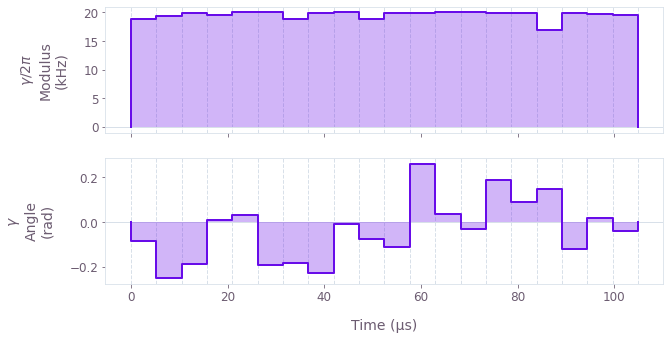

In [7]:
result = all_results["Standard"]["high_g"]
qv.plot_controls({f"$\\gamma$": result["output"]["ion_drive"]})

The above figure displays an exemplary optimized pulse modulus $\Omega (t)$ and phase $\phi (t)$ that addresses both ions. This control verifies that the maximum Rabi rate is consistently applied to obtain the fastest gate duration. 

We can also observe the *transformed* mode displacements: the trajectory of the center of a coherent state in (rotating) optical phase space for each mode.

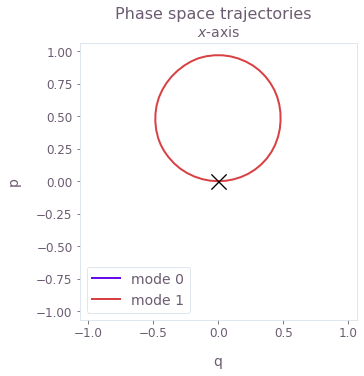

In [8]:
# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(result["output"]["displacements"]["value"], axis=3)
)

The above figure displays an example of a phase-space trajectory, chosen for $g=50$ kHz. Here, $q \equiv q_m = (a_m^\dagger + a_m)/\sqrt{2}$ and $p \equiv p_m = i (a_m^\dagger - a_m)/\sqrt{2}$ are the dimensionless quadratures for each mode $m$. Importantly, here only the center-of-mass mode mediates the operation, and the trajectory is displayed for the *transformed* mode. The trajectories are circular for the fastest gate durations and any parametric drive strength.

The black cross marks the final displacement for each mode: these are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.

### Generating robust pulses

Robustness to pulse timing errors and mode or laser frequency noise [can be obtained](https://doi.org/10.1002/qute.202000044) by imposing additional conditions on the system dynamics. Robustness to these noise sources is given by a combination of symmetry in each ion's drive, as described in [Milne et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022), and optimization such that the center of mass of each mode's trajectory is at zero. You can do this using the result of `graph.ions.ms_dephasing_robust_cost` as an extra term in the cost function. For more information, see the [How to optimize error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions) user guide.

It is important to note that satisfying these robustness conditions necessarily requires longer gate durations.
Additionally, since the mediating motional mode is transformed according to the trap parametric drive, the center of mass condition is calculated below for the *transformed* mode and does not precisely represent robustness to fluctuations in the *lab-frame* mode frequency. Using the robust optimization that follows, you can assess the impact of *lab frame* mode frequency fluctuations in the following section.

In the following cell, the parametric drive and laser detunings are specified as for the standard gates above, with the gate durations extended to accommodate robust solutions.

In [9]:
# Robust gate and control specifications.
all_parameters["Robust"] = {
    "no_g": {
        "g": 0,  # Hz
        "laser_detuning": 5.9e6 - 2.93e3,  # Hz
        "duration": 390e-6,  # s
    },
    "low_g": {
        "g": 2.9e3,  # Hz
        "laser_detuning": 5.9e6 - 5.005e3,  # Hz
        "duration": 295e-6,  # s
    },
    "high_g": {
        "g": 50e3,  # Hz
        "laser_detuning": 5.9e6 - 50.901e3,  # Hz
        "duration": 150e-6,  # s
    },
}

all_results["Robust"] = {}
for key, parameters in all_parameters["Robust"].items():
    drive_g = parameters["g"]
    laser_detuning = parameters["laser_detuning"]
    duration = parameters["duration"]

    result = optimize_single_drive(
        segment_count, drive_g, laser_detuning, duration, robust=True
    )

    all_results["Robust"][key] = result
    print(f"Drive strength: {drive_g / 1e3:.2f} kHz")
    print(f"Gate duration: {duration * 1e6:.2f} µs")
    print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
    print(f"Cost: {result['cost']:.3e}")
    print()

Your task (action_id="1827979") is queued.
Your task (action_id="1827979") has started.
Your task (action_id="1827979") has completed.
Drive strength: 0.00 kHz
Gate duration: 390.00 µs
Infidelity: 1.093e-03
Cost: 2.435e-03

Your task (action_id="1827981") is queued.
Your task (action_id="1827981") has started.
Your task (action_id="1827981") has completed.
Drive strength: 2.90 kHz
Gate duration: 295.00 µs
Infidelity: 1.794e-03
Cost: 7.383e-03

Your task (action_id="1827985") is queued.
Your task (action_id="1827985") has started.
Your task (action_id="1827985") has completed.
Drive strength: 50.00 kHz
Gate duration: 150.00 µs
Infidelity: 5.641e-05
Cost: 9.172e-05



We extract the controls and *transformed* phase-space displacement plots, as above.

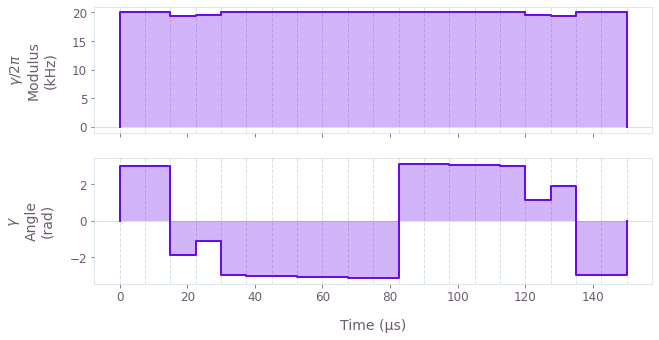

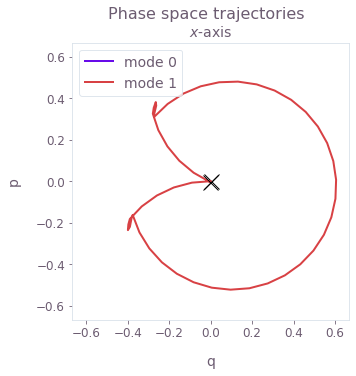

In [10]:
result = all_results["Robust"]["high_g"]
qv.plot_controls({f"$\\gamma$": result["output"]["ion_drive"]})

# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(result["output"]["displacements"]["value"], axis=3)
)

The complex control for the larger parametric drive (50 kHz) displayed above (chosen as an example) exhibits a Rabi rate close to the maximum value for most of its duration, while the phase exhibits more modulation over time. This control produces the symmetric *transformed* phase-space trajectory that satisfies the robustness condition for the transformed mode.

### Verifying robustness to dephasing errors with a quasi-static scan

We assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using [1D quasi-static error-susceptibility scans](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-evaluate-control-susceptibility-to-quasi-static-noise). This involves calculating the infidelity of the controls over a systematic scan of the relative detunings (which corresponds to shifting the laser detuning). Note that this shift is applied to the lab-frame modes, and the effect of this noise can then be calculated by proceeding with the mode transformations.

In [11]:
maxshift = 500  # Hz
scan_point_count = 31
shifts = np.linspace(-maxshift, maxshift, scan_point_count)

all_scans = {}
for robustness in all_parameters.keys():
    all_scans[robustness] = {}

    for key in all_parameters[robustness].keys():
        parameters = all_parameters[robustness][key]
        result = all_results[robustness][key]

        drive_g = parameters["g"]
        laser_detuning = parameters["laser_detuning"]
        duration = parameters["duration"]

        output_node_names = [
            f"{robustness}_{key}_{number}" for number in range(scan_point_count)
        ]

        graph = bo.Graph()

        for shift, infidelity_name in zip(shifts, output_node_names):
            # Set up trap modulation transformations.
            driven_relative_detunings = mode_frequencies - laser_detuning + shift
            delta_prime, r = calculate_modulation_parameters(
                driven_relative_detunings[0, 1], drive_g
            )
            driven_relative_detunings[0, 1] = delta_prime

            # Extract optimized drive.
            drive = graph.pwc(**result["output"]["ion_drive"])
            ion_drive_mod = drive * np.cosh(r) + graph.conjugate(drive) * np.sinh(r)
            drives = [ion_drive_mod] * ion_count

            # Calculate Mølmer–Sørensen quantities.
            ms_phases = graph.ions.ms_phases(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=driven_relative_detunings,
            )

            ms_displacements = graph.ions.ms_displacements(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=driven_relative_detunings,
            )

            ms_infidelity = graph.ions.ms_infidelity(
                phases=ms_phases,
                displacements=ms_displacements,
                target_phases=target_phases,
                name=infidelity_name,
            )

        # Run quasi-static scan.
        dephasing_scan = bo.execute_graph(graph, output_node_names)
        all_scans[robustness][key] = np.array(
            [dephasing_scan["output"][name]["value"] for name in output_node_names]
        )

Your task (action_id="1827988") is queued.
Your task (action_id="1827988") has started.
Your task (action_id="1827988") has completed.
Your task (action_id="1827990") has started.
Your task (action_id="1827990") has completed.
Your task (action_id="1827993") has started.
Your task (action_id="1827993") has completed.
Your task (action_id="1827995") has started.
Your task (action_id="1827995") has completed.
Your task (action_id="1827996") has started.
Your task (action_id="1827996") has completed.
Your task (action_id="1827997") has started.
Your task (action_id="1827997") has completed.


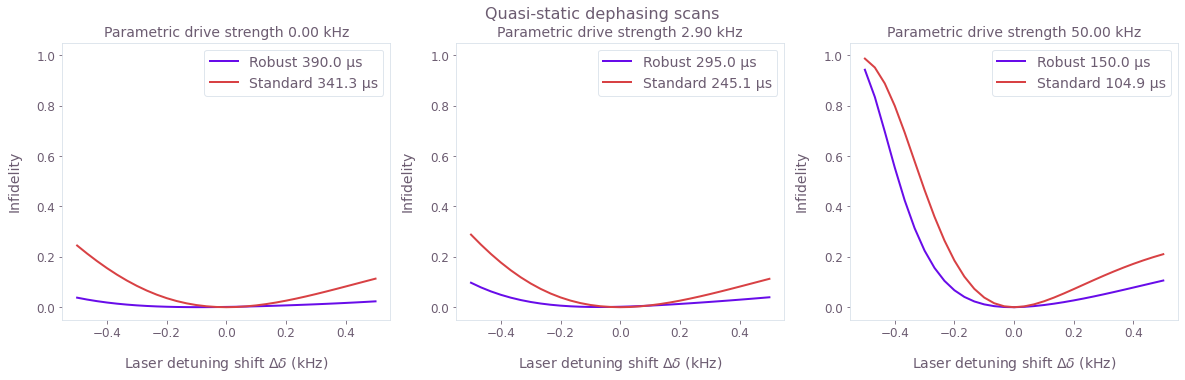

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Quasi-static dephasing scans")

for robustness in ["Robust", "Standard"]:
    for k, key in enumerate(["no_g", "low_g", "high_g"]):
        drive_g = all_parameters[robustness][key]["g"]
        duration = all_parameters[robustness][key]["duration"]
        label = f"{robustness} {duration*1e6:.1f} µs"
        axs[k].plot(shifts / 1e3, all_scans[robustness][key], label=label)
        axs[k].set_ylim((-0.05, 1.05))
        axs[k].set_title(f"Parametric drive strength {drive_g/1e3:.2f} kHz")
        axs[k].set_xlabel("Laser detuning shift $\\Delta \\delta$ (kHz)")
        axs[k].set_ylabel("Infidelity")
        axs[k].legend()
plt.show()

The broader high-fidelity region indicates the benefit of the robust optimized pulses when there is quasi-static dephasing noise, for each of the parametric drive strengths. The parametric drive impacts the mediating mode, and is treated by a transformation on the mode. Higher parametric drive strengths reduce the robustness to detuning (or similarly mode frequency) noise. This can be understood by the robustness condition using the *transformed* mode providing less robustness with respect to the *lab-frame* mode as the parametric drive grows.

Finally, notice from the legends that the robust gates are each faster than their standard counterparts that have lower (or no) parametric drive. Depending on the trap specifics and noise levels, the parametric drive strength could be chosen to enhance the gate time while giving rise only to acceptable noise susceptibility.

## Creating Boulder Opal pulses for two-qubit gates mediated by multiple modes

Mølmer–Sørensen-type operations can be mediated by more than a single mode; indeed this is necessary for more [complex multi-ion or parallel gate operations](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-configurable-parallel-gates-for-large-trapped-ion-arrays). This may also involve controls optimized individually for each ion to provide the necessary control degrees of freedom to perform the target operation. In this section, you can generate ion-specific modulated control drives that perform the target entangling gate mediated by multiple motional modes *in the presence of confining potential modulation*.

As before, consider a parametric trap drive modifying a single motional mode. Applying a normal mode transformation for this driven mode can again give rise to Mølmer–Sørensen dynamics, when combined with other transformations. As for the single-mode-mediated gate, the relative detunings are transformed, however the ion drives are not specific to the modified mode (the drives are coupled to each mode) and cannot be freely transformed. Instead, by enforcing that the ion drives are real, the Lamb–Dicke parameter terms associated with the modified motional mode can be transformed to recover the Mølmer–Sørensen Hamiltonian form. 

In this section, we use Boulder Opal to explore the impact of the trap modulation on two-ion gates mediated by both modes. 

First, specify the number and type of ions, as well as other trap and laser characteristics. Note that the maximum Rabi rate has been increased from the previous section to enhance the coupling to both modes, and this will also result in faster gates.

In [13]:
# Define trap and laser characteristics.
ion_count = 2
center_of_mass_frequencies = [5.9e6, 6.1e6, 1.5e6]
wavevector = [(2 * np.pi) / 355e-9, 0, 0]

maximum_rabi_rate = 2 * np.pi * 20e3 * 10


# Collect Lamb–Dicke parameters as an array of shape [<axis>, <collective_mode>, <ion>]
# and mode frequencies as an array of shape [<axis>, <collective_mode>].
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=25,  # Mg ions
    ion_count=ion_count,
    center_of_mass_frequencies=center_of_mass_frequencies,
    wavevector=wavevector,
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

# Target operation.
target_phases = np.array([[0, 0], [np.pi / 4, 0]])

Your task (action_id="1827998") has completed.


### Generating standard pulses

As above, here we demonstrate the fastest single-displacement-loop gate operations modified by the trap modulation. The following parameters have been chosen to characterize this operation, taking into account the transformations when a parametric drive with strength $g>0$ modifies a particular mode $p$. Here we specify that $p$ is the $x$-axis COM mode.

In [14]:
# Standard gate and control specifications.
all_parameters = {}
all_parameters["Standard"] = {
    "no_g": {
        "g": 0,  # Hz
        "laser_detuning": 5.9e6 - 29.3e3,  # Hz
        "duration": 34.2e-6,  # s
    },
    "with_g": {
        "g": 25e3,  # Hz
        "laser_detuning": 5.9e6 - 46.75e3,  # Hz
        "duration": 25.4e-6,  # s
    },
}

Next we optimize the drive control for the given parameters. In the following optimization, the real drives $\gamma_j (t) = \Omega_j (t)$ are separately optimized and individually address each ion $j$.

In [15]:
def optimize_multiple_drives(
    segment_count,
    drive_g,
    laser_detuning,
    duration,
    robust,
    sample_count=50,
    optimization_count=4,
):
    sample_times = np.linspace(0, duration, sample_count)
    drive_names = [f"ion_drive_{number}" for number in range(ion_count)]

    # Set up trap modulation transformations
    driven_relative_detunings = mode_frequencies - laser_detuning
    delta_prime, r = calculate_modulation_parameters(
        driven_relative_detunings[0, 1], drive_g
    )
    driven_relative_detunings[0, 1] = delta_prime

    # Transform the x-axis COM mode
    driven_lamb_dicke_parameters = lamb_dicke_parameters.copy()
    driven_lamb_dicke_parameters[0, 1] *= np.exp(r)  # sinh(r) + cosh(r)

    # Optimize the controls
    graph = bo.Graph()

    if robust:
        free_segment_count = int(np.ceil(segment_count / 2))
        drives = [
            graph.symmetrize_pwc(
                graph.real_optimizable_pwc_signal(
                    segment_count=free_segment_count,
                    duration=duration / 2,
                    maximum=maximum_rabi_rate,
                    minimum=-maximum_rabi_rate,
                ),
                name=drive_name,
            )
            for drive_name in drive_names
        ]
    else:
        drives = [
            graph.real_optimizable_pwc_signal(
                segment_count=segment_count,
                duration=duration,
                maximum=maximum_rabi_rate,
                minimum=-maximum_rabi_rate,
                name=drive_name,
            )
            for drive_name in drive_names
        ]

    ms_phases = graph.ions.ms_phases(
        drives=drives,
        lamb_dicke_parameters=driven_lamb_dicke_parameters,
        relative_detunings=driven_relative_detunings,
        sample_times=sample_times,
        name="phases",
    )
    ms_displacements = graph.ions.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=driven_lamb_dicke_parameters,
        relative_detunings=driven_relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )
    infidelity = graph.ions.ms_infidelity(
        phases=ms_phases[-1],
        displacements=ms_displacements[-1],
        target_phases=target_phases,
        name="infidelity",
    )

    if robust:
        robust_cost_term = graph.ions.ms_dephasing_robust_cost(
            drives=drives,
            lamb_dicke_parameters=driven_lamb_dicke_parameters,
            relative_detunings=driven_relative_detunings,
        )
        cost = infidelity + robust_cost_term
    else:
        cost = infidelity + 0.0
    cost.name = "cost"

    return bo.run_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["displacements", "infidelity", "phases"] + drive_names,
        optimization_count=optimization_count,
    )

In [16]:
segment_count = 20

all_results = {}
all_results["Standard"] = {}
for key, parameters in all_parameters["Standard"].items():
    drive_g = parameters["g"]
    laser_detuning = parameters["laser_detuning"]
    duration = parameters["duration"]

    result = optimize_multiple_drives(
        segment_count, drive_g, laser_detuning, duration, robust=False
    )

    all_results["Standard"][key] = result
    print(f"Drive strength: {drive_g / 1e3:.2f} kHz")
    print(f"Gate duration: {duration * 1e6:.2f} µs")
    print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
    print(f"Cost: {result['cost']:.3e}")
    print()

Your task (action_id="1827999") is queued.
Your task (action_id="1827999") has started.
Your task (action_id="1827999") has completed.
Drive strength: 0.00 kHz
Gate duration: 34.20 µs
Infidelity: 3.762e-11
Cost: 3.762e-11

Your task (action_id="1828000") has started.
Your task (action_id="1828000") has completed.
Drive strength: 25.00 kHz
Gate duration: 25.40 µs
Infidelity: 1.080e-05
Cost: 1.080e-05



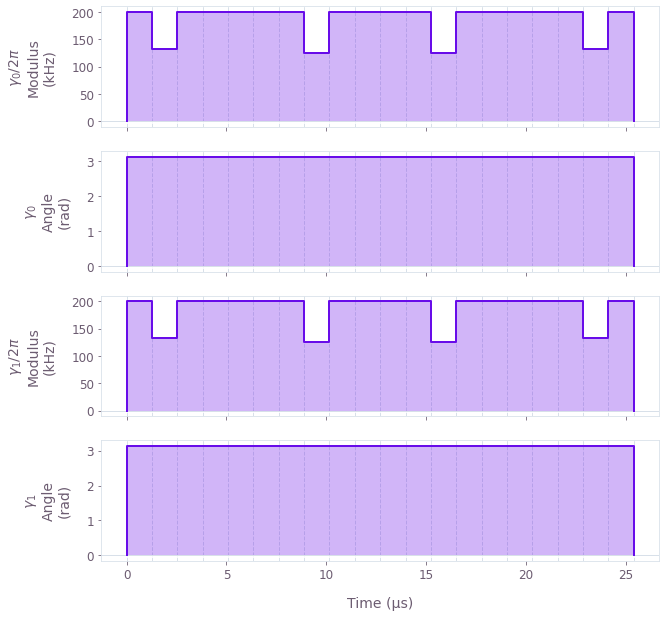

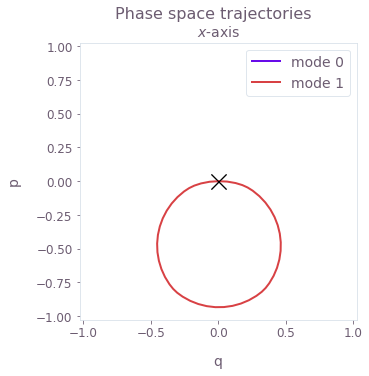

In [17]:
qv.plot_controls(
    {
        f"$\\gamma_{k}$": all_results["Standard"]["with_g"]["output"][f"ion_drive_{k}"]
        for k in range(ion_count)
    }
)

# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(
        all_results["Standard"]["with_g"]["output"]["displacements"]["value"], axis=3
    )
)

The real control with a parametric drive (25 kHz) is displayed above as an example. The control is close to the maximal Rabi rate throughout the gate, as expected for the minimal gate duration specified above. The *transformed* closed phase-space trajectory is also displayed for this control.

Although both modes can be displaced to mediate the gate, the minimal gate duration exploits the maximally-coupling (COM) mode to perform the operation as fast as possible. In the next section, we explore longer gate durations for robust operations.

### Generating robust pulses

As for the gate mediated by a single mode, we optimize the gate operation to satisfy robustness conditions. The conditions apply to the transformed mode as well as any additional displaced modes. In the following cell, the parametric drive and laser detunings are specified as for the standard gates above, with the gate durations extended to accommodate robust solutions.

In [18]:
# Robust gate and control specifications.
all_parameters["Robust"] = {
    "no_g": {
        "g": 0,  # Hz
        "laser_detuning": 5.9e6 - 29.3e3,  # Hz
        "duration": 50e-6,  # s
    },
    "with_g": {
        "g": 25e3,  # Hz
        "laser_detuning": 5.9e6 - 46.75e3,  # Hz
        "duration": 40e-6,  # s
    },
}

all_results["Robust"] = {}
for key, parameters in all_parameters["Robust"].items():
    drive_g = parameters["g"]
    laser_detuning = parameters["laser_detuning"]
    duration = parameters["duration"]

    result = optimize_multiple_drives(
        segment_count, drive_g, laser_detuning, duration, robust=True
    )

    all_results["Robust"][key] = result
    print(f"Drive strength: {drive_g / 1e3:.2f} kHz")
    print(f"Gate duration: {duration * 1e6:.2f} µs")
    print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
    print(f"Cost: {result['cost']:.3e}")
    print()

Your task (action_id="1828001") has started.
Your task (action_id="1828001") has completed.
Drive strength: 0.00 kHz
Gate duration: 50.00 µs
Infidelity: 9.921e-12
Cost: 2.991e-10

Your task (action_id="1828002") has started.
Your task (action_id="1828002") has completed.
Drive strength: 25.00 kHz
Gate duration: 40.00 µs
Infidelity: 1.230e-10
Cost: 3.103e-10



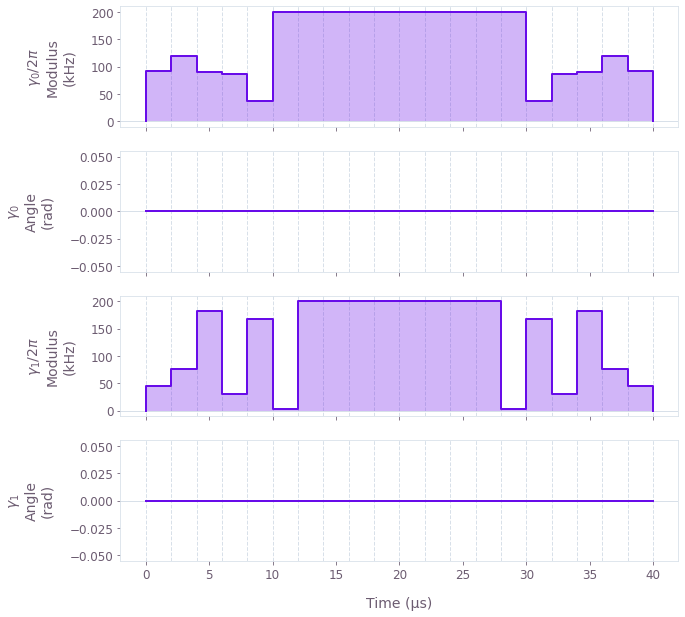

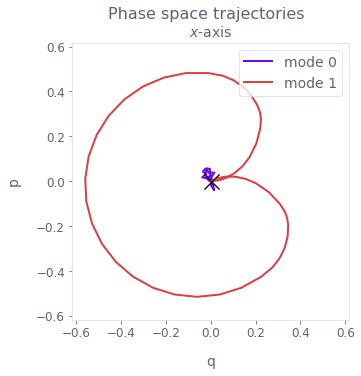

In [19]:
qv.plot_controls(
    {
        f"$\\gamma_{k}$": all_results["Robust"]["with_g"]["output"][f"ion_drive_{k}"]
        for k in range(ion_count)
    }
)

# Sum over ion index to obtain total displacement of the mode.
plot_phase_space_trajectories(
    np.sum(all_results["Robust"]["with_g"]["output"]["displacements"]["value"], axis=3)
)

The real control (the phase takes values of 0 or $\pi$) with a parametric drive (25 kHz) is displayed above as an example. Here both modes exhibit displacement and thus mediate the gate, with symmetry imposed by the robustness conditions on both the transformed mode (mode 1) and the lab-frame mode (mode 0). The gate is still primarily mediated by the transformed and more strongly-coupled COM mode. Both modes are restored to zero displacement at the end of the operation.

### Verifying robustness to dephasing errors with a quasi-static scan

We assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans. This involves calculating the infidelity of the controls over a systematic scan of the relative detunings (which corresponds to shifting the laser detuning). Note that this shift is applied to the lab-frame modes, and the effect of this noise can then be calculated by proceeding with the mode transformations.

In [20]:
maxshift = 1500  # Hz
scan_point_count = 31
shifts = np.linspace(-maxshift, maxshift, scan_point_count)

all_scans = {}
for robustness in all_parameters.keys():
    all_scans[robustness] = {}

    for key in all_parameters[robustness].keys():
        graph = bo.Graph()

        parameters = all_parameters[robustness][key]
        result = all_results[robustness][key]

        drive_g = parameters["g"]
        laser_detuning = parameters["laser_detuning"]
        duration = parameters["duration"]

        output_node_names = [
            f"{robustness}_{key}_{number}" for number in range(scan_point_count)
        ]

        for shift, infidelity_name in zip(shifts, output_node_names):
            # Set up trap modulation transformations.
            driven_relative_detunings = mode_frequencies - laser_detuning + shift
            delta_prime, r = calculate_modulation_parameters(
                driven_relative_detunings[0, 1], drive_g
            )
            driven_relative_detunings[0, 1] = delta_prime

            # Transform the x-axis COM mode.
            driven_lamb_dicke_parameters = lamb_dicke_parameters.copy()
            driven_lamb_dicke_parameters[0, 1] *= np.exp(r)  # sinh(r) + cosh(r)

            # Extract optimized drives.
            drives = [
                graph.pwc(**result["output"][f"ion_drive_{k}"])
                for k in range(ion_count)
            ]

            # Calculate Mølmer–Sørensen quantities.
            ms_phases = graph.ions.ms_phases(
                drives=drives,
                lamb_dicke_parameters=driven_lamb_dicke_parameters,
                relative_detunings=driven_relative_detunings,
            )
            ms_displacements = graph.ions.ms_displacements(
                drives=drives,
                lamb_dicke_parameters=driven_lamb_dicke_parameters,
                relative_detunings=driven_relative_detunings,
            )
            ms_infidelity = graph.ions.ms_infidelity(
                phases=ms_phases,
                displacements=ms_displacements,
                target_phases=target_phases,
                name=infidelity_name,
            )

        # Run quasi-static scan.
        dephasing_scan = bo.execute_graph(graph, output_node_names)
        all_scans[robustness][key] = np.array(
            [dephasing_scan["output"][name]["value"] for name in output_node_names]
        )

Your task (action_id="1828003") has started.
Your task (action_id="1828003") has completed.
Your task (action_id="1828004") has started.
Your task (action_id="1828004") has completed.
Your task (action_id="1828005") has started.
Your task (action_id="1828005") has completed.
Your task (action_id="1828006") has started.
Your task (action_id="1828006") has completed.


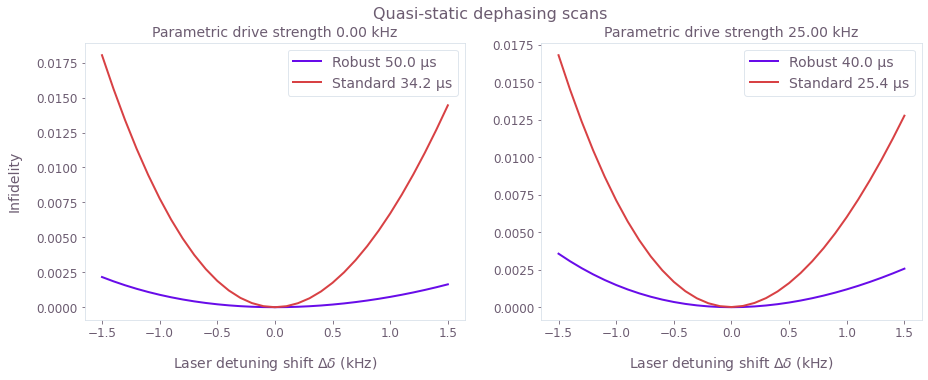

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Quasi-static dephasing scans")

for robustness in ["Robust", "Standard"]:
    for k, key in enumerate(["no_g", "with_g"]):
        drive_g = all_parameters[robustness][key]["g"]
        duration = all_parameters[robustness][key]["duration"]
        label = f"{robustness} {duration*1e6:.1f} µs"
        axs[k].plot(shifts / 1e3, all_scans[robustness][key], label=label)
        axs[k].set_title(f"Parametric drive strength {drive_g/1e3:.2f} kHz")
        axs[k].set_xlabel("Laser detuning shift $\\Delta \\delta$ (kHz)")
        axs[k].legend()
    axs[0].set_ylabel("Infidelity")
plt.show()

The broader high-fidelity region indicates the benefit of the robust optimized pulses when there is quasi-static dephasing noise, both with and without parametric trap modulation. This robustness is achieved by amplitude modulation of the ion drives in this case. Here the impact of the parametric drive on the gate robustness is minimal, and the higher-amplitude ion drives and faster gates have greatly enhanced the robustness over the previous quasi-static scans above. The parametric drive permits faster high-fidelity standard and robust solutions, as for the gate mediated by a single motional mode.